![logo](../../../LogoLine_horizon_C3S.png)

# Temporal and spatial completeness of the satellite-derived Ozone for policy making and variability studies


Production date: 06-06-2024

Produced by: Sandro Calmanti (ENEA), Chiara Volta (ENEA), Irene Cionni (ENEA)

## 🌍 Use case: Support policy on identifying and quantifying ozone recovery 

## ❓ Quality assessment questions

* **How well, in terms of completeness, does the longest Level-3 atmospheric ozone content data from merged satellite missions represent the variability of the ozone layer over time?**
* **How well data from merged satellite missions capture extreme events in ozone concentration?**

Assessing the return of the ozone layer to historical levels and the full recovery from ozone-depleting substances (ODS) under the 1987 Montreal Protocol is a critical task. The Montreal Protocol required the international scientific community to provide governments with regular updates on the latest scientific knowledge about the ozone layer. Since 1987, ten reports called "Scientific Assessment of Ozone Depletion" have been produced. These regular assessments have guided policymakers in strengthening the provisions of the Montreal Protocol. 

Satellite data undergoes several levels of processing before it can be used to provide decision-relevant information.

In this application, the Level-3 MERGED-UV dataset version v2000 is evaluated. A Level 3 dataset corresponds to data from a specific satellite sensor that has been quality tagged, converted to the relevant environmental variable, and aggregated on a uniform time-space grid. Level 3 datasets therefore represent a relatively low level of processing to produce usable data for decision making.

The MERGED-UV dataset combines total column ozone measurements at a 1°x1° spatial resolution from 5 UV nadir satellite sensors (i.e., GOME, SCIAMACHY, GOME-2A/B and OMI) [[1]](https://dast.copernicus-climate.eu/documents/satellite-ozone/C3S2_312a_Lot2_PUGS_O3_latest.pdf) , resulting in the longest L3 satellite product currently available (1995 to present).

## 📢 Quality assessment statements

```{admonition} These are the key outcomes of this assessment
:class: note
* The MERGED-UV v2000 provides a long-term, consistent record of total column ozone concentration and is therefore valuable for providing insight into the evolution of the ozone layer, although data prior to 2004 should be carefully evaluated.
* The MERGED-UV v2000 does not include measurements during the polar night at latitudes higher than 57.5° in both hemispheres and therefore cannot be used to describe the ozone climatology and trends over these regions.
* The lack of data in high-latitude regions during the polar night hinders the use of the MERGED-UV v2000 dataset to monitor the evolution of alarming ozone depletion at the poles.
* Data gaps in the polar region are a direct consequence of the decision to produce a long-term consistent ozone data set suitable for trend analysis. If data coverage is to be preferred to consistency, a better choice would be to use the ozone multi-sensor reanalysis (MSR) [[2]](https://doi.org/10.5194/amt-8-3021-2015) available from 1970 to present.
* Despite the data gaps, the MERGED-UV v2000 dataset reproduces the major ozone variations over time described in the literature.
* MERGED-UV v2000 captures episodes of extremely low regional total column ozone associated with the impact of volcanic eruptions.
```

## 📋 Methodology
This notebook has two main goals:

 - to show how the basic data coverage has changed over time and to highlight the potential impact on the accuracy of the final product;
 - to illustrate how the satellite orbit affects the seasonal data coverage and the resulting impact on the monitoring of total ozone over critical regions.

The methodology adopted for the analysis is split into the following steps:

[](satellite_satellite-ozone-v1_climate-monitoring_q01:sec1)
* Define data request and other parameters.
* Define required functions
    
[](satellite_satellite-ozone-v1_climate-monitoring_q01:sec2)
* Unit conversion
* Computation of time series
    
[](satellite_satellite-ozone-v1_climate-monitoring_q01:sec3)
* Discussion of data coverage
* Analysis of ozone distribution and its seasonal cycle
* Time series of total column ozone (TCO)

## 📈 Analysis and results

(satellite_satellite-ozone-v1_climate-monitoring_q01:sec1)=
### 1. Choose the data to use and setup the code

#### Define data request and other parameters

The analysis performed in this notebook focuses on the time series of the MERGED-UV total column ozone (TCO) over a period of 26 years (January 1996 - December 2022).  

Additionally, spatially weighted means and climatological monthly averages are computed at the global scale and over 5 latitudinal bands: polar (latitudes > 60°) and mid-latitude (30°<latitude<30°) regions in the Northern and Southern hemispheres, and the tropics (25°S<latitude<25°N). 

In [1]:
# Import packages
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils
plt.style.use("seaborn-v0_8-notebook")

# Time frame for the analysis
year_start = 1996
year_stop = 2022

# Variable to show
varname = "total_ozone_column"

collection_id = "satellite-ozone-v1"
requests = {
    "format": "zip",
    "processing_level": "level_3",
    "variable": "atmosphere_mole_content_of_ozone",
    "sensor": "merged_uv",
    "vertical_aggregation": "total_column",
    "year": [str(year) for year in range(year_start, year_stop + 1)],
    "month": [f"{month:02d}" for month in range(1, 12 + 1)],
    "version": "v2000",
}

# Regions
region_slices = {
    "global": {"lat_slice": slice(-90, 90), "lon_slice": slice(0, 360)},
    "tropics": {"lat_slice": slice(-25, 25), "lon_slice": slice(0, 360)},
    "NH mid-latitudes": {"lat_slice": slice(30, 60), "lon_slice": slice(0, 360)},
    "SH mid-latitudes": {"lat_slice": slice(-30, -60), "lon_slice": slice(0, 360)},
    "NH polar": {"lat_slice": slice(60, 90), "lon_slice": slice(0, 360)},
    "SH polar": {"lat_slice": slice(-60, -90), "lon_slice": slice(0, 360)},
}

#### Define required functions
For this dataset it is necessary to handle the time dimension carefully with a simple dedicated function like `add_time_dim`.  
The function `spatial_weighted_mean` is used to calculate ozone averages over the regions of interest.

In [2]:
def add_time_dim(ds):
    time = pd.to_datetime(ds.attrs["time_coverage_start"][:6], format="%Y%m")
    return ds.expand_dims(time=[time])


def spatial_weighted_mean(ds, lon_slice, lat_slice):
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    return diagnostics.spatial_weighted_mean(ds)

(satellite_satellite-ozone-v1_climate-monitoring_q01:sec2)=
### 2. Data retrieval

The full dataset is retrieved, including information on the number of observations used to compute the monthly TCO at each grid point. All TCO is then converted in Dobson Unit (DU) by multiplying ozone data (in mol m$^{-2}$) by the conversion coefficient provided in the dataset as a metadata attribute.

The computation of the time series of TCO over the regions of interest is performed by applying a weighted mean to the gridded data.

In [3]:
kwargs = {
    "collection_id": collection_id,
    "requests": requests,
    "chunks": {"year": 1},
    "preprocess": add_time_dim,
}

# Full dataset
ds_full = download.download_and_transform(**kwargs)
da = ds_full[varname]
with xr.set_options(keep_attrs=True):
    da = da * da.attrs["multiplication_factor_to_convert_to_DU"]
da.attrs["units"] = "DU"

# Timeseries
datasets = []
for region, transform_func_kwargs in region_slices.items():
    print(f"{region=}")
    ds = download.download_and_transform(
        **kwargs,
        transform_func=spatial_weighted_mean,
        transform_func_kwargs=transform_func_kwargs,
        drop_variables="time_bounds",
        quiet = True
    )
    datasets.append(ds.expand_dims(region=[region]))
ds_timeseries = xr.concat(datasets, "region")


100%|██████████| 27/27 [00:00<00:00, 59.02it/s]


region='global'
region='tropics'
region='NH mid-latitudes'
region='SH mid-latitudes'
region='NH polar'
region='SH polar'


(satellite_satellite-ozone-v1_climate-monitoring_q01:sec3)=
### 3. Plot and describe the results

#### Data Coverage
The global map of data coverage shows that the number of observations decreases from 57.5° poleward in both hemispheres. As shown in the latitudinal time series, this reduction is due to the fact that the dataset does not include measurements during the polar night (i.e., winter and summer months in the northern and the southern hemisphere, respectively). The time series also shows reduced observations between 1996 and 2002, a period during which GOME was the only active sensor. Since 2002, the number of observations slightly increases due to the activation of SCIAMACHY. In 2004, the activation of a third sensor (OMI) strongly enhanced the data coverage. Since then, the data coverage has been guaranteed over time by using at least three sensors simultaneously [[1]](https://dast.copernicus-climate.eu/documents/satellite-ozone/C3S2_312a_Lot2_PUGS_O3_latest.pdf). Small, non-periodic reductions in the number of observations are visible after 2004 and are likely to depend on differences in the sensors and satellites used over time, such as their orbital period and swath [[3]](https://dast.copernicus-climate.eu/documents/satellite-ozone/C3S2_312a_Lot2_ATBD_O3_latest.pdf). Small, but periodic reductions are due to differences in the length of the months (e.g., February).

A significant impact of data coverage on the accuracy of the total ozone content can be derived as a by-product of the data assimilation process for the elaboration of the multi-sensor reanalysis [[2]](https://doi.org/10.5194/amt-8-3021-2015), which is also available on the CDS as the MSR dataset. Increasing the number of measurements used to derive the mean total ozone column by about an order of magnitude (e.g., between 2000 and 2020) corresponds to reducing the absolute error from about 20 DU to about 7 DU, which corresponds to reducing the expected error from about 6% to about 2% [[2]](https://doi.org/10.5194/amt-8-3021-2015).

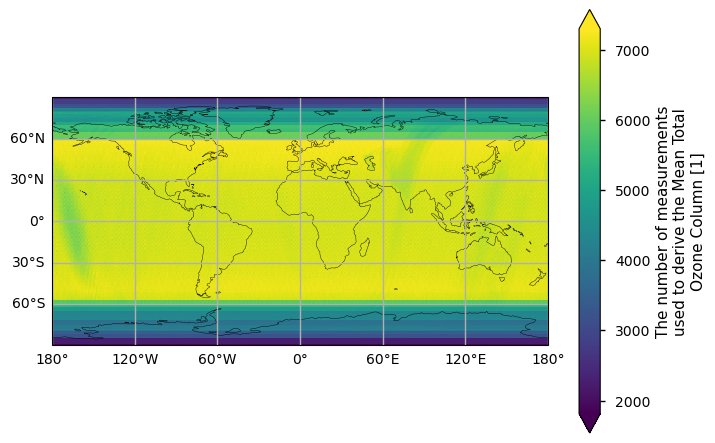

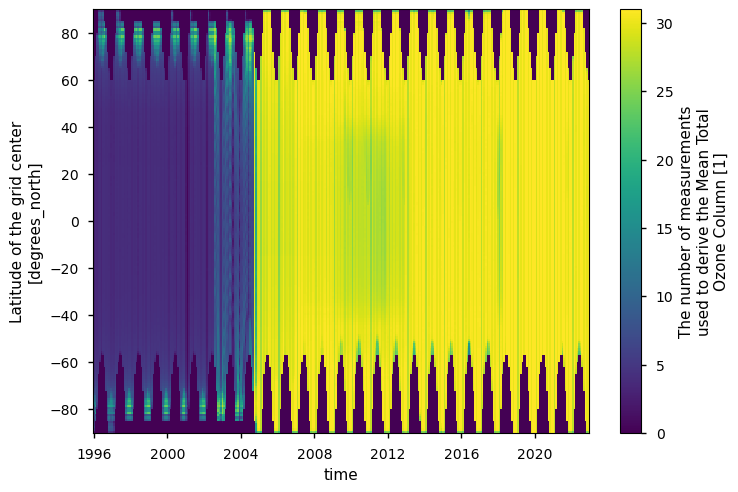

In [4]:
da_obs = ds_full[f"{varname}_number_of_observations"]
da_obs.attrs["long_name"] = da_obs.attrs["long_name"].replace("use","used")
plot.projected_map(da_obs.sum(dim="time", keep_attrs=True), show_stats=False, extend='both')
plt.show()

with xr.set_options(keep_attrs=True):
    da_sum = da_obs.sum("longitude", keep_attrs=True) / da_obs.sizes["longitude"]
_ = da_sum.plot(x="time")

#### Total column ozone distribution and seasonal cycle
The global map of total column ozone (TCO) shows that TCO varies strongly with latitude. The highest TCO values are observed at latitudes around 60°S and above 30°N due to the poleward transport of tropical ozone by stratospheric air circulation [[4]](https://doi.org/10.1002/2013RG000448). As a result, tropical regions become ozone-depleted. Low TCO values are also observed below 60°S, where the Antarctic ozone hole is located [[5]](https://doi.org/10.1038/315207a0) [[6]](https://doi.org/10.1126/science.aae0061).

The Hövmoller plot of the climatological monthly TCO means shows that the seasonal variability of ozone levels is small in the tropics and larger above 35° in both hemispheres. The dataset MERGED-UV is able to reproduce the TCO climatology in the tropics and mid-latitudes, with an expected maximum over eastern Asia at about 60°N and the largest TCO values over the northern polar region during winter with TCO above 410 DU [[7]](https://doi.org/10.5194/acp-11-9237-2011). However it fails to reproduce the full climatology in polar regions due to the unavailability of data during the polar night from  57.5° poleward in both hemispheres. In particular, the dataset partially captures the TCO depletion typically observed in early autumn and during the austral spring above and below 60° N and S, respectively, but cannot reproduce the low TCO levels typically observed in early austral autumn [[8]](https://doi.org/10.1029/1999RG900008) [[9]](https://ozone.unep.org/sites/default/files/2023-05/Final_20Qs%202022%20full%20document_26April2023_digital%20version-reduced_0.pdf).

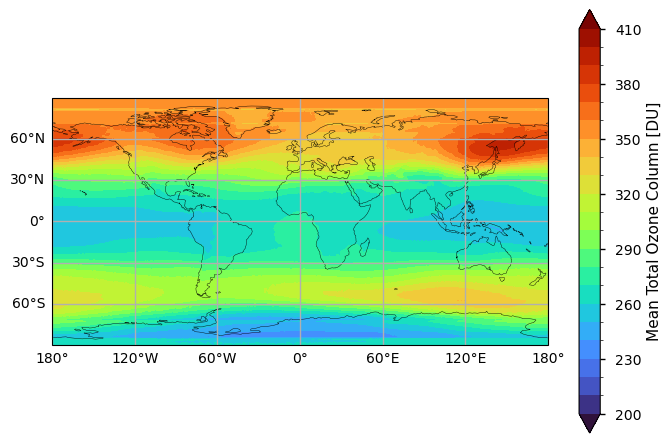

In [5]:

contour_kwargs = {"levels": range(200, 420, 10), "extend": "both", "cmap": "turbo"}
map = plot.projected_map(
    da.mean("time", keep_attrs=True),
    plot_func="contourf",
    show_stats=False,
    **contour_kwargs,
)

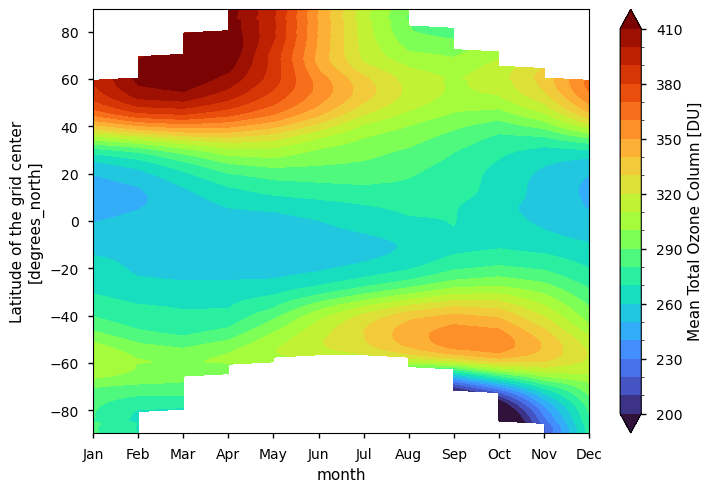

In [6]:
da_annual_cycle = da.groupby("time.month").mean(["time", "longitude"], keep_attrs=True)
da_annual_cycle["month"] = [
    calendar.month_abbr[m] for m in da_annual_cycle["month"].values
]
_ = da_annual_cycle.plot.contourf(x="month", **contour_kwargs)

#### Time series 
The deseasonalized monthly time series show the limited inter-annual variability at the global scale and over the tropics and mid-latitudes, compared to the larger variability observed over the polar regions. The time series show that the dataset is able to detect documented large variations, such as the large TCO depletion in the Arctic in 2011 and 2020, and the re-emergence of the large, long-lived ozone hole over Antarctica since 2020 due to anomalous circulation patterns [[10]](https://doi.org/10.1038/s41467-023-42637-0) [[11]](https://doi.org/10.1029/2022JD037581). The unique split in the ozone hole that occurred in the second half of 2002 is clearly visible, with anomalies above 50 DU compared to the expected seasonal cycle, consistent with more detailed analysis presented in dedicated studies [[12]](https://doi.org/10.1175/JAS-3338.1). Extremely low TCO levels, triggered by the Calbuco eruption, are also observed below 30°S in 2015 [[6]](https://doi.org/10.1126/science.aae0061). In 2010, high TCO levels are observed at mid-latitudes in the Northern Hemisphere due to simultaneous negative phases of the Arctic and North Atlantic Oscillation [[13]](https://doi.org/10.1029/2010GL046634). High TCO levels, induced by the stratospheric warming over Antarctica, are also observed in the southernmost region in 2019 [[14]](https://doi.org/10.1029/2020GL087810). Furthermore, the time series show that the dataset is able to reproduce the quasi-biennial oscillation in tropical ozone [[15]](https://doi.org/10.1029/2002JD002170).

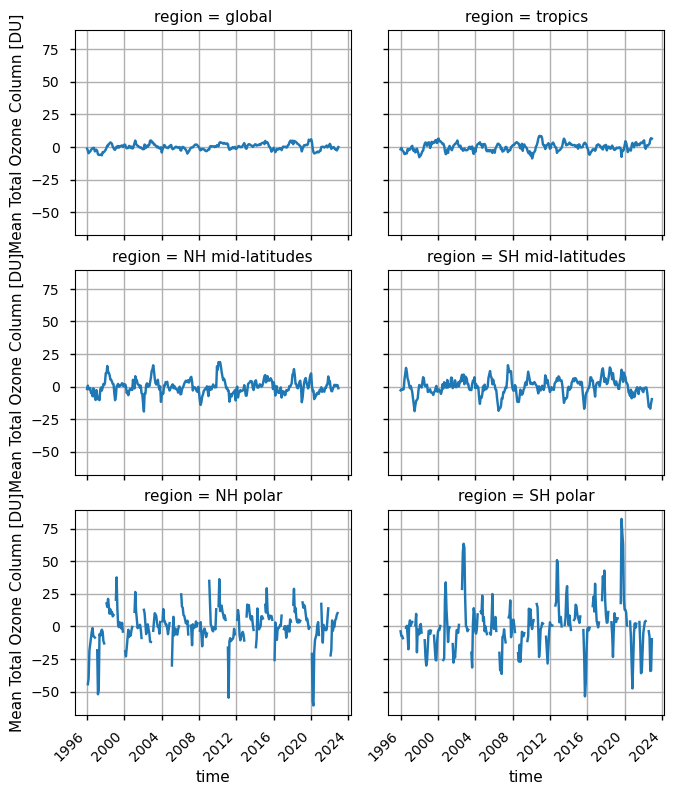

In [7]:
with xr.set_options(keep_attrs=True):
    da_anomaly = (
        ds_timeseries[varname].groupby("time.month")
        - ds_timeseries[varname].groupby("time.month").mean()
    )
    da_anomaly *= da_anomaly.attrs["multiplication_factor_to_convert_to_DU"]
da_anomaly.attrs["units"] = "DU"
facet = da_anomaly.plot(row="region", col_wrap=2)
for ax in facet.axs.flatten():
    ax.grid()
facet.fig.autofmt_xdate(rotation=45)

## ℹ️ If you want to know more
### Key resources
* CDS catalog entry used in this notebook is the [Ozone monthly gridded data from 1970 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-ozone-v1?tab=overview)
* Data download from CDS is available [here](https://cds.climate.copernicus.eu/datasets/satellite-ozone-v1?tab=download)
* A Product User Guide and Specification is available on the [Satellite Ozone Catalogue Entry of the CDS](https://cds.climate.copernicus.eu/datasets/satellite-ozone-v1?tab=documentation).

Code libraries used:
* [C3S EQC custom function](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [B-Open](https://www.bopen.eu/)

### References

[[1]](https://dast.copernicus-climate.eu/documents/satellite-ozone/C3S2_312a_Lot2_PUGS_O3_latest.pdf) Van Roozendael, M., et al. (2021a). Ozone Product User Guide and Specification (PUGS). Last access: March 27, 2024

[[2]](https://doi.org/10.5194/amt-8-3021-2015) van der A, R.J., et al. (2015). Extended and refined multi sensor reanalysis of total ozone for the period 1970-2012. Atmospheric Measurement Techniques, 8, 3021-3035. 

[[3]](https://dast.copernicus-climate.eu/documents/satellite-ozone/C3S2_312a_Lot2_ATBD_O3_latest.pdf) Van Roozendael, M., et al. (2021b). Ozone Algorithm Theoretical Basis Document (ATBD). Last access: March 28, 2024

[[4]](https://doi.org/10.1002/2013RG000448) Butchart, N. (2014). The Brewer-Dobson circulation. Review of Geophysics, 52(2), 157-184. 

[[5]](https://doi.org/10.1038/315207a0) Farman, J.C., et al. (1985). Large losses of total ozone in Antarctica reveal seasonal ClO$_x$/NO$_x$ interaction. Nature, 315, 207-210. 

[[6]](https://doi.org/10.1126/science.aae0061) Solomon, S., Ivy, D. J., Kinnison, D., Mills, M. J., Neely III, R. R., & Schmidt, A. (2016). Emergence of healing in the Antarctic ozone layer. Science, 353(6296), 269-274. 

[[7]](https://doi.org/10.5194/acp-11-9237-2011) Ziemke, J. R., Chandra, S., Labow, G. J., Bhartia, P. K., Froidevaux, L., & Witte, J. C. (2011). A global climatology of tropospheric and stratospheric ozone derived from Aura OMI and MLS measurements. Atmospheric Chemistry and Physics, 11(17), 9237-9251. 

[[8]](https://doi.org/10.1029/1999RG900008) Solomon, S. (1999). Stratospheric ozone depletion: A review of concepts and history. Review of Geophysics, 37(3), 275-316. 

[[9]](https://ozone.unep.org/sites/default/files/2023-05/Final_20Qs%202022%20full%20document_26April2023_digital%20version-reduced_0.pdf) Ross, J.S., et al. (2023). Twenty Questions and Answers About the Ozone Layer: 2022 Update, Scientific Assessment of Ozone Depletion: 2022, 75 pp., WMO, Geneva, Switzerland.

[[10]](https://doi.org/10.1038/s41467-023-42637-0) Kessenich, H.E., et al. (2023). Potential drivers of the recent large Antarctic ozone holes. Nature Communications, 14, 7259. 

[[11]](https://doi.org/10.1029/2022JD037581) Petkov, B.H., et al. (2023. Un Unprecedented Arctic Ozone Depletion Evnet During Spring 2020 and Its Impacts Across Europe. Journal of Geophysical Research: Atmospheres, 128, e2022JD037581. 

[[12]](https://doi.org/10.1175/JAS-3338.1) Stolarski, R. S., McPeters, R. D., & Newman, P. A. (2005). The ozone hole of 2002 as measured by TOMS. Journal of the atmospheric sciences, 62(3), 716-720.

[[13]](https://doi.org/10.1029/2010GL046634) Steinbrecht, W., et al. (2011). Very high ozone columns at northern mid-latitudes in 2010. Geophysical research Letters, 38, L06803. 

[[14]](https://doi.org/10.1029/2020GL087810) Safieddine, S., et al. (2020). Antarctic ozone enhancement during the 2019 sudden stratospheric warming event. Geophysical Research Letters,47,e2020GL087810. 

[[15]](https://doi.org/10.1029/2002JD002170) Logan, J.A., et al. (2003). Quasibiennial oscillation in tropical ozone as revealed by ozonesonde and satellite date. Journal of Geophysical Research, 108, 4244(D8). 